# Wildfire Risk - Model - Script-based Approach
__Team 3 - Dave Friesen, John Chen, and Kyle Dalope__<br>
__ADS-508-02-SP23__<br><br>
__GitHub link: https://github.com/davefriesen/wildfire-risk__

In [1]:
__authors__ = ['Dave Friesen', 'John Chen', 'Kyle Dalope']
__contact__ = ['dfriesen@sandiego.edu', 'johnchen@sandiego.edu', 'kdalope@sandiego.edu']
__date__ = '2023-03-20'
__license__ = 'MIT'
__version__ = '1.0.2'

# Setup

In [2]:
# Import basic and data access libraries
import pandas as pd
from profiler import profile, profile_cat

# Import utility libraries
import h3

# Data Load

In [3]:
df = pd.read_csv('../data/merged.csv', low_memory=False)

# [. . .]

In [4]:
#
df = df.drop(columns=[
    'ContainmentDateTime',
    'ControlDateTime',
    'DiscoveryAcres',
    'EstimatedCostToDate',
    'FinalAcres',
    'FireCause',
    'FireBehaviorGeneral',
    'FireBehaviorGeneral1',
    'FireBehaviorGeneral2',
    'FireBehaviorGeneral3',
    'FireCauseGeneral',
    'FireCauseSpecific',
    'FireDiscoveryDateTime',
    'FireOutDateTime',
    'GACC',
    'IncidentName',
    'IncidentShortDescription',
    'InitialLatitude',
    'InitialLongitude',
    'IsFireCauseInvestigated',
    'IsTrespass',
    'POOCity',
    'POOState',
    'PredominantFuelModel',
    'PrimaryFuelModel',
    'ym_date'    
])

#pd.set_option('display.max_rows', 100)
profile(df)

,Dtype,count,unique,na,na%,mean,std,min,max,skew(>=3),<v0.01,VIF(>=10),examples
STATION,object,42289,418,,,,,,,,,,USR0000OBUS__USR0000
LATITUDE,float64,42289,416,,,40.9,4.3,32.6,49.0,,,3364.2,42.1197__43.6806__39
LONGITUDE,float64,42289,409,,,-120.7,2.2,-124.3,-114.5,,,205.0,-122.5633__-122.3019
ELEVATION,float64,42289,332,,,1046.3,542.1,,2748.7,,,,847.3__1028.1__599.8
NAME,object,42289,418,,,,,,,,,,BUCKHORN SPRINGS ORE
...,...,...,...,...,...,...,...,...,...,...,...,...,...
STATE,object,42289,3,,,,,,,,,,OR__OR__CA__OR__OR
WATERCD,float64,30631,7,11658,27.6,0.5,1.4,,9.0,,,,0.0__0.0__0.0__0.0__
LAT,float64,42289,2254,,,40.9,4.3,32.6,49.0,,,547.2,42.038118__43.686686
LON,float64,42289,2253,,,-120.7,2.2,-124.3,-114.5,,,53.7,-122.603232__-122.35


# Modeling (iteration n)

In [5]:
# Import model and performance evaluation libraries
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import LinearSVC

from sklearn.neighbors import KNeighborsClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from sklearn.neural_network import MLPClassifier

# Import custom model library
from model_process import ModelProcess

# Import utility libraries
import copy

In [6]:
ignore_cols = ['STATION', 'LATITUDE', 'LONGITUDE', 'NAME', 'geohash', 'year', 'month', 'PLT_CN',
               'STATE', 'LAT', 'LON', 'FireCause']

cat_nominal_cols = ['CDSD_ATTRIBUTES', 'CLDD_ATTRIBUTES', 'DT00_ATTRIBUTES', 'DT32_ATTRIBUTES',
                    'DX32_ATTRIBUTES', 'DX70_ATTRIBUTES', 'DX90_ATTRIBUTES', 'EMNT_ATTRIBUTES',
                    'EMXT_ATTRIBUTES', 'HDSD_ATTRIBUTES', 'HTDD_ATTRIBUTES', 'TAVG_ATTRIBUTES',
                    'TMAX_ATTRIBUTES', 'TMIN_ATTRIBUTES']
cat_ordinal_cols = []
cat_binary_cols = []

num_interval_cols = ['COND_STATUS_CD']
num_ratio_cols = ['ELEVATION', 'CDSD', 'CLDD', 'DT00', 'DT32', 'DX32', 'DX70', 'DX90',
                  'EMNT', 'EMXT', 'HDSD', 'HTDD', 'TAVG', 'TMAX', 'TMIN', 'MAPDEN',
                  'STDAGE', 'STDSZCD', 'FLDSZCD', 'SITECLCD', 'SICOND', 'STDORGCD',
                  'SLOPE', 'PHYSCLCD', 'GSSTKCD', 'DSTRBCD1', 'TRTCD1', 'PRESNFCD',
                  'FLDAGE', 'CARBON_DOWN_DEAD', 'CARBON_LITTER', 'CARBON_SOIL_ORG',
                  'CARBON_STANDING_DEAD', 'CARBON_UNDERSTORY_AG', 'CARBON_UNDERSTORY_BG',
                  'WATERCD']

target_cls_col = ['fire']

reduce_X_cols = ignore_cols + target_cls_col

In [7]:
df_X = df.loc[:, ~df.columns.isin(reduce_X_cols)].copy()
df_y = df[target_cls_col]

In [8]:
train_ratio = 0.7; val_ratio = 0.20; test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(
    df_X, df_y, test_size=1-train_ratio, 
    random_state=42, stratify=df_y)
X_val, X_test, y_val, y_test = train_test_split(
    X_test, y_test, test_size=test_ratio/(test_ratio+val_ratio),
    random_state=42, stratify=y_test)

trows = df_X.shape[0]
print('\nTrain/validation/test: ', X_train.shape[0], '/', X_val.shape[0], '/', X_test.shape[0])

profile_cat(y_train, target_cls_col)


Train/validation/test:  29602 / 8458 / 4229

fire - 
 0.0  76.991419
 1.0  23.008581


In [9]:
# Set feature cols for appropriate pipeline preprocessing
cat_cols = cat_nominal_cols + cat_ordinal_cols + cat_binary_cols  # one-hot encoding, imputing (if necc)
num_cols = num_interval_cols + num_ratio_cols  # scaling, imputing (if necc)

# Set model list
mp_queue = (
    (LogisticRegression(), {'random_state': 42}),
    (Perceptron(), {'class_weight': 'balanced'}),
    (LinearDiscriminantAnalysis(), None),
    (LinearSVC(), {'max_iter': 500}),

    (KNeighborsClassifier(), {'n_neighbors': 3}),
    (KNeighborsClassifier(), {'n_neighbors': 5}),
    (KNeighborsClassifier(), {'n_neighbors': 7}),

    (DecisionTreeClassifier(), {'max_depth': 4, 'random_state': 42}),
    (DecisionTreeClassifier(), {'max_depth': 5, 'random_state': 42}),

    (RandomForestClassifier(), {'max_depth': 4, 'random_state': 42}),
    (RandomForestClassifier(), {'max_depth': 5, 'random_state': 42}),

    (AdaBoostClassifier(), {'n_estimators': 10, 'random_state': 42}),

    (MLPClassifier(), {'random_state': 42}),
)

In [10]:
ModelProcess.show_progress = True

# Iterate models (note use of 'copy' is to preserve mutable elements
#   of model_queue tuple for possible later use)
mp_df = pd.DataFrame(mp_queue, columns=['algorithm', 'params'])
mp_df['mp'] = mp_df.apply(
    lambda mp: ModelProcess(copy.deepcopy(mp['algorithm']), None,
                            copy.copy(mp['params']),
                            X_train, y_train,
                            X_val, y_val,
                            X_test, y_test,
                            None,
                            cat_cols, num_cols).train_validate_test(), axis=1)

# Compile, sort, and display results
mp_df[['train_acc', 'train_f1', 'train_time',
       'val_acc', 'val_f1', 'val_time',
       'test_acc', 'test_f1', 'test_time']] =\
    mp_df['mp'].apply(
        lambda mp: sum(list(map(
            lambda dataset: mp.score[dataset] + [mp.time[dataset]], ['train', 'val', 'test'])), [])).tolist()
mp_df.sort_values(by=['train_acc', 'val_acc', 'test_acc'],
                  ascending=[False, False, False], inplace=True)
#mp_df.loc[:, mp_df.columns != 'mp'].to_csv('results_table.csv')    

LogisticRegression: train... done in 2.97s.
LogisticRegression: val... done in 0.09s.
LogisticRegression: test... done in 0.04s.
Perceptron: train... done in 0.54s.
Perceptron: val... done in 0.04s.
Perceptron: test... done in 0.02s.
LinearDiscriminantAnalysis: train... done in 2.61s.
LinearDiscriminantAnalysis: val... done in 0.07s.
LinearDiscriminantAnalysis: test... done in 0.04s.
LinearSVC: train... done in 3.31s.
LinearSVC: val... done in 0.04s.
LinearSVC: test... done in 0.02s.
KNeighborsClassifier: train... done in 11.93s.
KNeighborsClassifier: val... done in 3.74s.
KNeighborsClassifier: test... done in 2.10s.
KNeighborsClassifier: train... done in 12.75s.
KNeighborsClassifier: val... done in 4.37s.
KNeighborsClassifier: test... done in 1.81s.
KNeighborsClassifier: train... done in 11.92s.
KNeighborsClassifier: val... done in 3.73s.
KNeighborsClassifier: test... done in 1.95s.
DecisionTreeClassifier: train... done in 0.68s.
DecisionTreeClassifier: val... done in 0.07s.
DecisionT

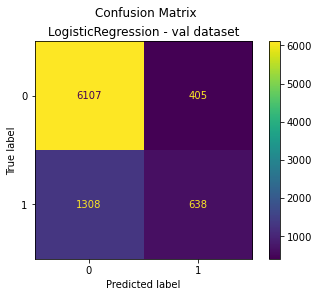



LogisticRegression - val dataset

              precision    recall  f1-score   support

         0.0       0.82      0.94      0.88      6512
         1.0       0.61      0.33      0.43      1946

    accuracy                           0.80      8458
   macro avg       0.72      0.63      0.65      8458
weighted avg       0.77      0.80      0.77      8458



In [11]:
# Show confusion matrix and summary for Logistic Regression
mp_df.loc[0]['mp'].confusion_matrix('val')
mp_df.loc[0]['mp'].summary('val')

In [12]:
# Show top features for Logistic Regression (this could be 'baked' into the
#   ModelProcess() class or similar in future)
model = mp_df.loc[0]['mp'].model
features = mp_df.loc[0]['mp'].pipe['preprocessor'].transformers_[0][1]['onehotencoder'].get_feature_names_out(cat_cols)
fi = pd.concat([pd.DataFrame(features, columns=['feature']),
                pd.DataFrame(num_cols, columns=['feature'])],
               ignore_index=True)

fi['importance'] = model.coef_[0]
fi['abs_importance'] = abs(fi['importance'])
fi.sort_values(by=['abs_importance', 'feature'],
               ascending=[False, True], inplace=True)
fi[fi['abs_importance'] >= 0.50][['feature', 'importance']]

,feature,importance
281,"EMXT_ATTRIBUTES_,U,20,+",-1.303098
130,"EMNT_ATTRIBUTES_1,U,14,",1.244018
263,"EMXT_ATTRIBUTES_,U,11,+",1.210691
253,"EMXT_ATTRIBUTES_,U,06,+",1.136581
271,"EMXT_ATTRIBUTES_,U,15,+",-1.128018
99,"EMNT_ATTRIBUTES_,U,29,",1.090370
320,"EMXT_ATTRIBUTES_1,U,11,",0.967075
90,"EMNT_ATTRIBUTES_,U,24,+",-0.929640
430,"EMXT_ATTRIBUTES_3,U,31,",0.911657
220,"EMNT_ATTRIBUTES_3,U,26,",0.898710


In [13]:
mp_df

,algorithm,params,mp,train_acc,train_f1,train_time,val_acc,val_f1,val_time,test_acc,test_f1,test_time
12,MLPClassifier(),{'random_state': 42},<model_process.ModelProcess object at 0x7f9a40...,0.997433,0.994416,126.819230,0.893710,0.773495,0.104808,0.903760,0.794962,0.077519
4,KNeighborsClassifier(),{'n_neighbors': 3},<model_process.ModelProcess object at 0x7f9a34...,0.923890,0.832801,11.932051,0.855167,0.687101,3.743675,0.848664,0.674466,2.104629
5,KNeighborsClassifier(),{'n_neighbors': 5},<model_process.ModelProcess object at 0x7f9a34...,0.893284,0.759827,12.750957,0.849846,0.662951,4.365158,0.847245,0.660358,1.812251
6,KNeighborsClassifier(),{'n_neighbors': 7},<model_process.ModelProcess object at 0x7f9a34...,0.877745,0.720346,11.915284,0.848546,0.651618,3.729759,0.845826,0.647568,1.948880
8,DecisionTreeClassifier(),"{'max_depth': 5, 'random_state': 42}",<model_process.ModelProcess object at 0x7f9a01...,0.802750,0.438935,0.729751,0.793805,0.420213,0.069053,0.797825,0.424242,0.038858
0,LogisticRegression(),{'random_state': 42},<model_process.ModelProcess object at 0x7f9a01...,0.796737,0.426898,2.968530,0.797470,0.426899,0.087076,0.804445,0.457705,0.037665
3,LinearSVC(),{'max_iter': 500},<model_process.ModelProcess object at 0x7f9a01...,0.796162,0.405751,3.309331,0.793568,0.397931,0.037892,0.802081,0.426319,0.019845
2,LinearDiscriminantAnalysis(),None,<model_process.ModelProcess object at 0x7f9a50...,0.795115,0.454341,2.606584,0.795105,0.448265,0.071421,0.805391,0.484013,0.038614
7,DecisionTreeClassifier(),"{'max_depth': 4, 'random_state': 42}",<model_process.ModelProcess object at 0x7f9a01...,0.785589,0.347084,0.681959,0.778316,0.332503,0.068768,0.786238,0.334315,0.038433
11,AdaBoostClassifier(),"{'n_estimators': 10, 'random_state': 42}",<model_process.ModelProcess object at 0x7f9a40...,0.776198,0.399420,1.754442,0.776070,0.402900,0.125567,0.787420,0.433522,0.068093
